<a href="https://colab.research.google.com/github/thinh12112001/Ryerson_MRP/blob/master/VGG16_training_data_04_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = 150, 150
NUM_CLASSES = 2
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimer_s Dataset/temp/test",
    image_size=IMAGE_SIZE,
    batch_size=40,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
IMAGE_SIZE = (150, 150)
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=40,
)



In [ ]:
NUM_CLASSES = 2
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
#val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

VGG16 transfer learning-fine-tunning



Found 5120 images belonging to 2 classes.


<ipython-input-7-9899f5877f6d>:39: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = model.predict_generator(


Found 1280 images belonging to 2 classes.


<ipython-input-7-9899f5877f6d>:50: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = model.predict_generator(


Train: [0 0 0 ... 1 1 1]
Validation: [0 0 0 ... 1 1 1]
Epoch 1/100
128/128 [==============================] - 1s 5ms/step - loss: 0.7973 - accuracy: 0.5799 - val_loss: 0.6105 - val_accuracy: 0.7164
Epoch 2/100
128/128 [==============================] - 1s 4ms/step - loss: 0.6262 - accuracy: 0.6473 - val_loss: 0.5653 - val_accuracy: 0.7414
Epoch 3/100
128/128 [==============================] - 1s 4ms/step - loss: 0.5953 - accuracy: 0.6811 - val_loss: 0.5309 - val_accuracy: 0.7305
Epoch 4/100
128/128 [==============================] - 1s 4ms/step - loss: 0.5703 - accuracy: 0.6994 - val_loss: 0.5105 - val_accuracy: 0.7531
Epoch 5/100
128/128 [==============================] - 0s 3ms/step - loss: 0.5531 - accuracy: 0.7145 - val_loss: 0.5050 - val_accuracy: 0.7492
Epoch 6/100
128/128 [==============================] - 0s 4ms/step - loss: 0.5356 - accuracy: 0.7318 - val_loss: 0.5372 - val_accuracy: 0.7023
Epoch 7/100
128/128 [==============================] - 0s 3ms/step - loss: 0.5175 - acc

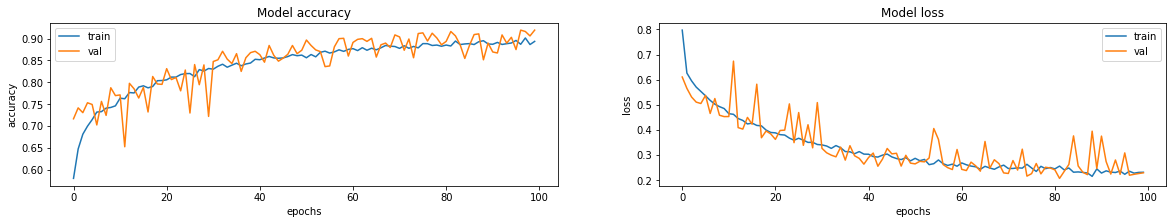

In [7]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import applications
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
import matplotlib.pyplot as plt

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_04.h5'
train_data_dir = '/content/drive/MyDrive/colab/data_04/train'
validation_data_dir = '/content/drive/MyDrive/colab/data_04/validation'
# test_data_dir = '/content/drive/MyDrive/Alzheimer_s Dataset/temp/test'
nb_train_samples = 5120
nb_validation_samples = 1280
epochs = 100
batch_size = 40
# history_train = ""
history_test = ""

def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    for layer in model.layers:
      layer.trainable = False
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * 2560+ [1] * 2560 )

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * 640+ [1] * 640 )

    print ("Train:", train_labels)
    print ("Validation:", validation_labels)
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) #0.5 gốc
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    history_train = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history_train.history[met])
        ax[i].plot(history_train.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        model.save(top_model_weights_path)
    

save_bottlebeck_features()
train_top_model()

Visualize the result 

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_train.history[met])
    ax[i].plot(history_train.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

VGG16-NONE


In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_VGG16_00.h5'
train_data_dir = '/content/drive/MyDrive/colab/data_04/train'
validation_data_dir = '/content/drive/MyDrive/colab/data_04/validation'
nb_train_samples = 5120
nb_validation_samples = 1280
epochs = 100
batch_size = 40


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights=None)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * 2560+ [1] * 2560 )

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * 640+ [1] * 640 )

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save(top_model_weights_path)


save_bottlebeck_features()
train_top_model()